# Библиотеки

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip -q install rdkit-pypi
!pip -q install Pillow
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 74.6 MB/s eta 0:00:00


In [2]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import urllib
import math
import pennylane as qml

RDLogger.DisableLog("rdApp.*")

# Датасет

SMILES: Cn1cncc1O
Num heavy atoms: 7


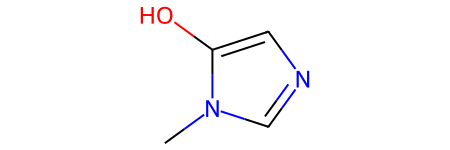

In [3]:
csv_path, _ = urllib.request.urlretrieve(
    "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv", "qm9.csv"
)

data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])


# Проверка
smiles = data[1000]
print("SMILES:", smiles)
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

# Молекула -> Граф

(5, 20, 20) (20, 5)


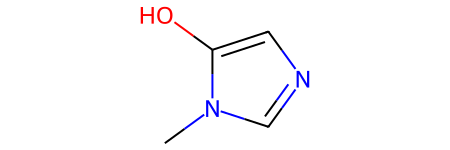

In [4]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

NUM_ATOMS = 20  # Максимальное кол-во атомов в молекуле
ATOM_DIM = 4 + 1  # Количество типов атомов в молекуле
BOND_DIM = 4 + 1  # Количество связей
LATENT_DIM = 64  # Размерность пр-ва признаков

def smiles_to_graph(smiles):
    # SMILES -> mol
    molecule = Chem.MolFromSmiles(smiles)
    # Кекулизация чтобы избежать подоюных соединений
    Chem.Kekulize(molecule)

    # Матрица смежности и признаков
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")#float 64 при втором квантовом дискриминаторе
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # Проходит по каждому атому в молекуле
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # проходит по соседним атомам
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Где нет связей - единица
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Где нет атома - единица
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    adjacency, features = graph

    # RWMol - объект который можно редактировать
    molecule = Chem.RWMol()

    # Удаляет несуществующие атомы и атомы без связей
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Добавляет все символы, руководствуясь словарем atom_mapping
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Добавляет связи основываясь на матрице смежности
    # (переберает верхний треугольник из-за симметрии)
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Санитизируем молекулу, на самом деле не очень понял зачем ее везде используют, что-то вроде удаления неккоректностей, помогает избегать ошибок, посмотрел по ссылке
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Если санитизация не удалась, то ничего не возвращаем
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


# Проверка
adjacency, features = smiles_to_graph(smiles)
print(adjacency.shape, features.shape)
graph_to_molecule(smiles_to_graph(smiles))

# Создаем класс для датасета

In [5]:
class QM9Dataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()

    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        adjacency, features = smiles_to_graph(data[idx])
        return torch.tensor(adjacency), torch.tensor(features)

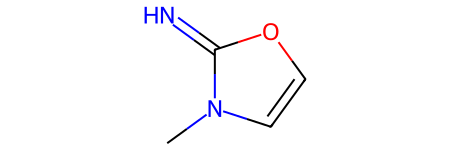

In [6]:
dataset = QM9Dataset()
adjacency, features = dataset[1002]
graph_to_molecule((adjacency.numpy(), features.numpy()))

# Генератор

In [11]:
class MolGenerator(nn.Module):
    def __init__(self, nlatent, nhiddens, dropout, adj_shape, feat_shape):
        super().__init__()

        self.nlatent = nlatent
        nlayers = [nlatent, *nhiddens]
        mods = []
        for nin, nout in zip(nlayers[:-1], nlayers[1:]):
            mods.append(nn.Linear(nin, nout))
            mods.append(nn.Tanh())
            mods.append(nn.Dropout(dropout))

        self.base = nn.Sequential(*mods)
        self.adj = nn.Linear(nlayers[-1], np.prod(adj_shape))
        self.adj_shape = adj_shape
        self.feat = nn.Linear(nlayers[-1], np.prod(feat_shape))
        self.feat_shape = feat_shape

    def forward(self, x):
        h = self.base(x)
        adj = self.adj(h).view(-1, *self.adj_shape)
        adj = 0.5*(adj + adj.transpose(-1, -2))
        adj = adj.softmax(1)
        feat = self.feat(h).view(-1, *self.feat_shape)
        feat = feat.softmax(2)
        return adj, feat


# Попытки квантового генератора

In [10]:
class MolGenerator(qml.QNode):
    def __init__(self, func, device, nlatent, nhiddens, dropout, adj_shape, feat_shape):
        super().__init__(func, device)
        self.nlatent = nlatent
        nlayers = [nlatent, *nhiddens]
        self.mods = []
        for nin, nout in zip(nlayers[:-1], nlayers[1:]):
            self.mods.append(qml.templates.AngleEmbedding(nin, range(2)))
            self.mods.append(qml.templates.BasicEntanglerLayers(nout))
            self.mods.append(qml.templates.PauliRotations(nout))
            self.mods.append(qml.templates.BasicEntanglerLayers(nout))
            self.mods.append(qml.templates.AngleEmbedding(nin))
            self.mods.append(qml.templates.PauliRotations(nin))

        self.adj = qml.templates.AngleEmbedding(np.prod(adj_shape))
        self.adj_shape = adj_shape
        self.feat = qml.templates.AngleEmbedding(np.prod(feat_shape))
        self.feat_shape = feat_shape
        self.dropout = qml.qnn.Dropout(dropout)

    def forward(self, x):
        batch_size, input_dim = x.shape
        x = x.reshape(batch_size, input_dim)
        for mod in self.mods:
            mod(x)
        adj = self.adj(x).reshape(-1, *self.adj_shape)
        adj = 0.5*(adj + adj.transpose(-1, -2))
        adj = adj.softmax(1)
        feat = self.feat(x).reshape(-1, *self.feat_shape)
        feat = feat.softmax(2)
        return adj, feat

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(x, weights):
    qml.RX(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

# Проверка совместимости генератора

In [12]:
from pennylane.devices import default_qubit
gen = MolGenerator(64, [128, 256, 512], 0.2, (BOND_DIM, NUM_ATOMS, NUM_ATOMS), (NUM_ATOMS, ATOM_DIM))#circuit, qml.device("default.qubit", 9)#,
adj, feat = gen.forward(torch.randn(4, 64))
print(adj.shape)
print(feat.shape)

torch.Size([4, 5, 20, 20])
torch.Size([4, 20, 5])


# Свертка графов

In [13]:
class RGConv(nn.Module):
    def __init__(self, nbond, nin, nout, act=F.relu, bias=False):
        super().__init__()
        self.act = act

        self.weight = nn.Parameter(torch.zeros(nbond, nin, nout))
        self.bias = None
        if bias:
            nn.Parmeter(torch.zeros(nbond, 1, nout))
        self._init_param()

    def _init_param(self):
        nn.init.xavier_uniform_(self.weight, nn.init.calculate_gain(self.act.__name__))

    def forward(self, adj, feat):
        x = torch.einsum("bijk,bkl->bijl", adj, feat)
        x = torch.einsum("bijk,ikl->bijl", x, self.weight)
        if self.bias is not None:
            x += self.bias
        x = self.act(x.sum(1))
        return x

In [14]:
gen = MolGenerator(64, [128, 256, 512], 0.2, (BOND_DIM, NUM_ATOMS, NUM_ATOMS), (NUM_ATOMS, ATOM_DIM))
adj, feat = gen.forward(torch.randn(4, 64))
print(adj.shape)
print(feat.shape)
rgcn1 = RGConv(BOND_DIM, ATOM_DIM, 64)
rgcn2 = RGConv(BOND_DIM, 64, 128)
feat = rgcn1(adj, feat)
print(feat.shape)
feat = rgcn2(adj, feat)
print(feat.shape)
print(rgcn1)

torch.Size([4, 5, 20, 20])
torch.Size([4, 20, 5])
torch.Size([4, 20, 64])
torch.Size([4, 20, 128])
RGConv()


#Дискриминатор

In [15]:
class MolDiscriminator(nn.Module):
    def __init__(self, ngcn, nfc, dropout, adj_shape, feat_shape):
        super().__init__()

        nbond = adj_shape[0]
        nfeat = feat_shape[-1]

        nlayers = [nbond, *ngcn]
        self.gcn_mods = nn.ModuleList()
        for nin, nout in zip(nlayers[:-1], nlayers[1:]):
            self.gcn_mods.append(RGConv(nbond, nin, nout))

        nlayers = [nout, *nfc]
        mods = []
        for nin, nout in zip(nlayers[:-1], nlayers[1:]):
            mods.append(nn.Linear(nin, nout))
            mods.append(nn.ReLU())
            mods.append(nn.Dropout(dropout))

        mods.append(nn.Linear(nout, 1))
        mods.append(nn.Flatten())
        self.fc = nn.Sequential(*mods)



    def forward(self, adj, feat):
        x = feat
        for mod in self.gcn_mods:
            x = mod(adj, x)
        x = x.mean(1)
        x = self.fc(x)
        return x

# Попытки квантовых дискриминаторов

In [ ]:
dev = qml.device("default.qubit", wires=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
@qml.qnode(dev)
def circuit(x, weights):
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

class MolDiscriminator(qml.QNode):
    def __init__(self, func, device, interface, ngcn, nfc, dropout, adj_shape, feat_shape):
        super().__init__(func, device, interface = 'torch')

        self.nbond = adj_shape[0]
        self.nfeat = feat_shape[-1]

        self.nlayers_gcn = [self.nbond, *ngcn]
        self.gcn_mods = []
        for nin, nout in zip(self.nlayers_gcn[:-1], self.nlayers_gcn[1:]):
            self.gcn_mods.append(qml.RY(nin, wires=nin))
            self.gcn_mods.append(qml.RZ(nin, wires=nin))
            self.gcn_mods.append(qml.RY(nout, wires=nin))

        self.nlayers_fc = [self.nlayers_gcn[-1], *nfc]
        mods = []
        for nin, nout in zip(self.nlayers_fc[:-1], self.nlayers_fc[1:]):
            mods.append(nn.Tanh())
            mods.append(nn.Dropout(dropout))

        self.fc = nn.Sequential(*mods)

    def forward(self, adj, feat):
        x = feat
        for mod in self.gcn_mods:
            mod(x)
        x = x.mean(1)
        return self.fc(x)

In [ ]:
ATOM_NUM = 20
n_circuites = ATOM_NUM
n_qubits = 5

n_measured_wire = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #NTS: use GPU runtime
dev = qml.device('default.qubit', wires=n_qubits)

MEASURED_QUBIT_IDX = 4#int(sys.argv[1])

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(inputs, weights):
    qml.templates.AmplitudeEmbedding(inputs, wires=range(n_qubits), pad_with=0.001, normalize=(True))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(MEASURED_QUBIT_IDX, MEASURED_QUBIT_IDX+1)]

n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

class MolDiscriminator(nn.Module):
    def __init__(self, ngcn, nfc, dropout, adj_shape, feat_shape):
        super().__init__()
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)


        nbond = adj_shape[0]
        nfeat = feat_shape[-1]

        nlayers = [nbond, *ngcn]
        self.gcn_mods = nn.ModuleList()
        for nin, nout in zip(nlayers[:-1], nlayers[1:]):
            self.gcn_mods.append(RGConv(nbond, nin, nout))

        nlayers = [nout, *nfc]
        mods = []
        for nin, nout in zip(nlayers[:-1], nlayers[1:]):
            mods.append(nn.Linear(nin, nout))
            mods.append(nn.ReLU())
            mods.append(nn.Dropout(dropout))

        mods.append(nn.Linear(nout, 1))
        mods.append(nn.Flatten())
        self.fc = nn.Sequential(*mods)



    def forward(self, adj, feat):
        x = feat
        for mod in self.gcn_mods:
            x = mod(adj, x)
        x = x.mean(1)
        x = self.fc(x)
        x = self.qlayer_1(x)
        return x

# Проверка совместимости дискриминатора

In [16]:
dis = MolDiscriminator(ngcn=[128, 128, 128, 128], nfc=[512, 512], dropout=0.2,
                       adj_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
                       feat_shape=(NUM_ATOMS, ATOM_DIM))
print(dis)
adj, feat = gen.forward(torch.randn(4, 64))
print(adj.shape)
print(feat.shape)
print(dis(adj, feat))

MolDiscriminator(
  (gcn_mods): ModuleList(
    (0-3): 4 x RGConv()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
)
torch.Size([4, 5, 20, 20])
torch.Size([4, 20, 5])
tensor([[-0.0019],
        [-0.0124],
        [-0.0225],
        [-0.0302]], grad_fn=<AddmmBackward0>)


# Класс GAN'а

In [17]:
class GPMolGAN:
    def __init__(self, generator, discriminator, gopt, dopt,
                 generator_steps=1, discriminator_steps=1,
                 gp_weight=10.0):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

        self.generator_steps = generator_steps
        self.discriminator_steps = discriminator_steps
        self.gp_weight = gp_weight

        self.gopt = gopt
        self.dopt = dopt

    def train_step(self, adj_real, feat_real):
        loss_g, loss_d = 0.0, 0.0
        for _ in range(self.discriminator_steps):
            latent_vec = torch.randn(feat_real.shape[0], self.generator.nlatent, device="cuda:0")
            adj_fake, feat_fake = self.generator(latent_vec)
            logits_real = self.discriminator(adj_real, feat_real)
            logits_fake = self.discriminator(adj_fake, feat_fake)
            loss_discriminator = logits_fake.mean() - logits_real.mean()
            # Штрафы
            alpha = torch.rand(feat_real.shape[0], device="cuda:0")
            alpha1 = alpha.reshape(-1, 1, 1, 1)
            alpha2 = alpha.reshape(-1, 1, 1)
            adj_interp = adj_real*alpha1 + adj_fake*(1.0 - alpha1)
            feat_interp = feat_real*alpha2 + feat_fake*(1.0 - alpha2)
            logits = self.discriminator(adj_interp, feat_interp).sum()
            adj_grad, feat_grad = torch.autograd.grad(logits,
                                                      [adj_interp, feat_interp],
                                                      create_graph=True,
                                                      retain_graph=True)
            adj_grad_penalty = (1 - adj_grad.norm(dim=1))**2
            feat_grad_penalty = (1 - adj_grad.norm(dim=2))**2
            loss_gp = adj_grad_penalty.mean() + feat_grad_penalty.mean()

            loss = loss_discriminator + self.gp_weight*loss_gp
            loss_d = loss.item()

            self.dopt.zero_grad()
            loss.backward()
            self.dopt.step()

        for _ in range(self.generator_steps):
            latent_vec = torch.randn(feat_real.shape[0], self.generator.nlatent, device="cuda:0")
            adj_fake, feat_fake = self.generator(latent_vec)
            logits_fake = self.discriminator(adj_fake, feat_fake)
            loss = -logits_fake.mean()
            loss_g = loss.item()

            self.gopt.zero_grad()
            loss.backward()
            self.gopt.step()
        print("\r", f"Discriminator loss: {loss_d:12.6f}, Generator loss: {loss_g:12.6f}", end="")

# Инициализация модели и датасета

In [20]:
generator = MolGenerator(nlatent=128, nhiddens=[256, 512, 512], dropout=0.2,
                         adj_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
                         feat_shape=(NUM_ATOMS, ATOM_DIM))
print(generator)
discriminator = MolDiscriminator(ngcn=[256, 256, 256, 256], nfc=[512, 512], dropout=0.2,
                       adj_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
                       feat_shape=(NUM_ATOMS, ATOM_DIM))
print(discriminator)
generator.cuda()
discriminator.cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4)
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4)
trainer = GPMolGAN(generator, discriminator, gopt, dopt)

MolGenerator(
  (base): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.2, inplace=False)
  )
  (adj): Linear(in_features=512, out_features=2000, bias=True)
  (feat): Linear(in_features=512, out_features=100, bias=True)
)
MolDiscriminator(
  (gcn_mods): ModuleList(
    (0-3): 4 x RGConv()
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
)


In [21]:
dataset = QM9Dataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
for adj, feat in dataloader:
    print(adj.shape, feat.shape)
    break

torch.Size([256, 5, 20, 20]) torch.Size([256, 20, 5])


# Обучение

In [22]:
NEPOCHS = 100
print("Start training...")
generator.train()
discriminator.train()
for epoch in range(NEPOCHS):
    print("\n", f"In epoch #{epoch:04d}")
    for adj, feat in dataloader:
        adj, feat = adj.cuda(), feat.cuda()
        trainer.train_step(adj, feat)
print("\n", "Training ended...")

Start training...

 In epoch #0000
 Discriminator loss:   -41.052402, Generator loss:    34.187992
 In epoch #0001
 Discriminator loss:   -22.361927, Generator loss:   -12.107203
 In epoch #0002
 Discriminator loss:   -17.830040, Generator loss:    17.894787
 In epoch #0003
 Discriminator loss:   -17.524258, Generator loss:     1.793462
 In epoch #0004
 Discriminator loss:   -14.260877, Generator loss:    25.609087
 In epoch #0005
 Discriminator loss:    -6.182253, Generator loss:   -19.102839
 In epoch #0006
 Discriminator loss:   -18.432446, Generator loss:     6.029023
 In epoch #0007
 Discriminator loss:   -16.181213, Generator loss:     4.433306
 In epoch #0008
 Discriminator loss:    -6.562361, Generator loss:    11.087193
 In epoch #0009
 Discriminator loss:    -4.909264, Generator loss:    -2.789523
 In epoch #0010
 Discriminator loss:    -1.963981, Generator loss:     9.094904
 In epoch #0011
 Discriminator loss:    -2.293823, Generator loss:    10.750841
 In epoch #0012
 Disc

# Вывод молекул, как изображений

torch.Size([128, 5, 20, 20]) torch.Size([128, 20, 5])
torch.Size([128, 5, 20, 20]) torch.Size([128, 20, 5])


/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


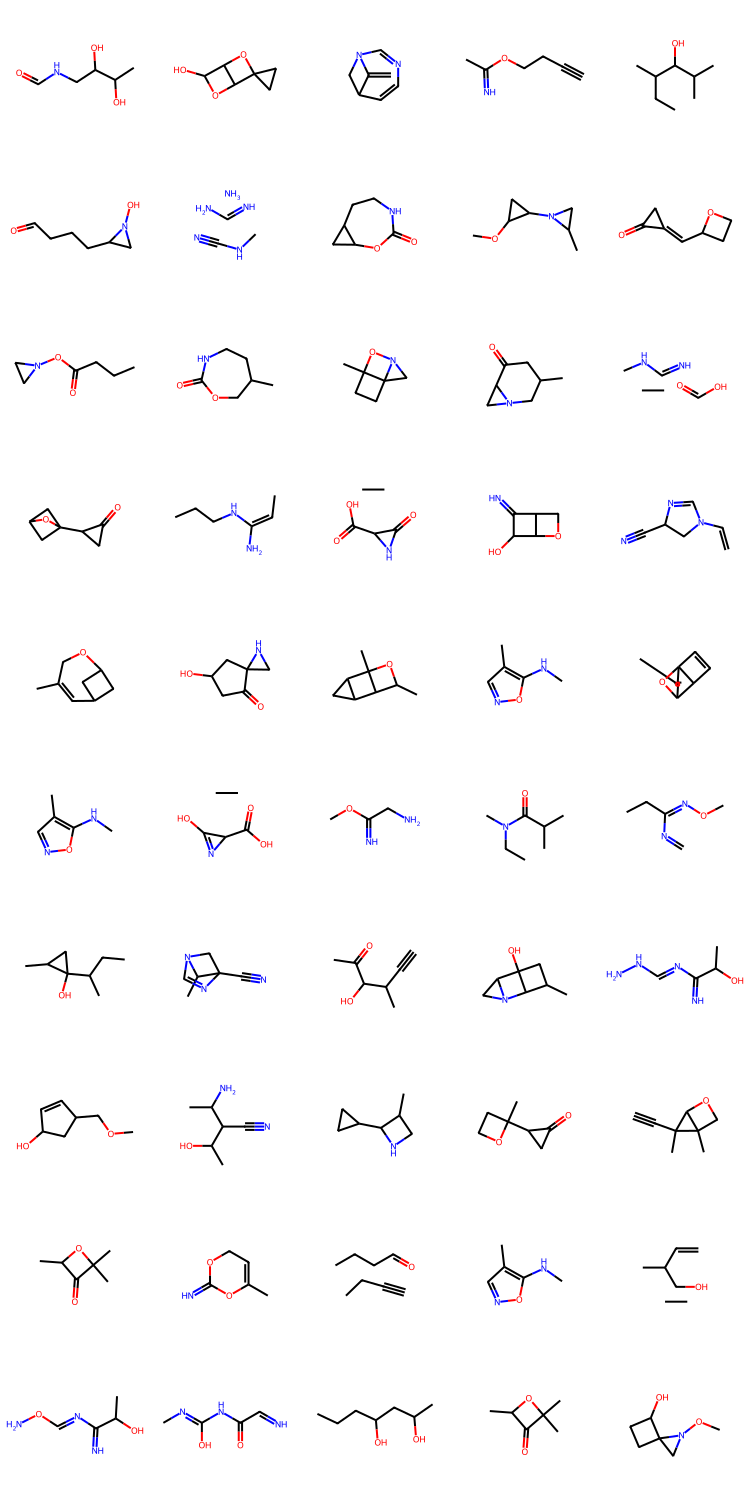

In [23]:
generator.eval()
adj, feat = generator(torch.randn(128, 128).cuda())
print(adj.shape, feat.shape)
adj = adj.argmax(1)
adj = F.one_hot(adj, num_classes=BOND_DIM).permute([0, 3, 1, 2])
# убираем самоповторения
idx = torch.arange(ATOM_DIM)
adj[..., idx, idx] = 0
feat = feat.argmax(2)
feat = F.one_hot(feat, num_classes=ATOM_DIM)
print(adj.shape, feat.shape)
mols = [graph_to_molecule([adj[i].cpu().numpy(), feat[i].cpu().numpy()])
        for i in range(adj.shape[0])]

MolsToGridImage(
    [m for m in mols if m is not None][:], molsPerRow=5, subImgSize=(150, 150)
)

In [24]:
print(dis)

MolDiscriminator(
  (gcn_mods): ModuleList(
    (0-3): 4 x RGConv()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
)
